# Classifiers and Advanced Features

In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix,ConfusionMatrixDisplay, make_scorer
import matplotlib.pyplot as plt
import seaborn as sb

In [80]:
dataset_10 = pd.read_csv('../../data/dataset/processed_datasets/feature_selection/data_encoded_10_features.csv')
dataset_20 = pd.read_csv('../../data/dataset/processed_datasets/feature_selection/data_encoded_20_features.csv')
dataset_all = pd.read_csv('../../data/dataset/processed_datasets/feature_selection/data_encoded_full_dataset.csv')
df_under_10 = pd.read_csv('../../data/dataset/processed_datasets/feature_selection/resample_encoded_10_features.csv')
df_under_20 = pd.read_csv('../../data/dataset/processed_datasets/feature_selection/resample_encoded_20_features.csv')
df_under_all = pd.read_csv('../../data/dataset/processed_datasets/feature_selection/resample_encoded_full_dataset.csv')

## Train Test Splitting

In [58]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_sets = {}
test_sets = {}

for df, name in zip([dataset_10, dataset_20, dataset_all, df_under_10, df_under_20, df_under_all], 
                   ['10', '20', 'all', 'under_10', 'under_20', 'under_all']):
    for train_index, test_index in split.split(df, df["HeartDisease_Yes"]):
        train_sets[name] = df.loc[train_index]
        test_sets[name] = df.loc[test_index]

In [60]:
X_train_10 = train_sets['10'].drop("HeartDisease_Yes", axis=1)
y_train_10 = train_sets['10']["HeartDisease_Yes"] 
X_test_10 = test_sets['10'].drop("HeartDisease_Yes", axis=1)
y_test_10 = test_sets['10']["HeartDisease_Yes"] 

X_train_20 = train_sets['20'].drop("HeartDisease_Yes", axis=1)
y_train_20 = train_sets['20']["HeartDisease_Yes"] 
X_test_20 = test_sets['20'].drop("HeartDisease_Yes", axis=1)
y_test_20 = test_sets['20']["HeartDisease_Yes"] 

X_train_all = train_sets['all'].drop("HeartDisease_Yes", axis=1)
y_train_all = train_sets['all']["HeartDisease_Yes"] 
X_test_all = test_sets['all'].drop("HeartDisease_Yes", axis=1)
y_test_all = test_sets['all']["HeartDisease_Yes"] 

X_train_under_10 = train_sets['under_10'].drop("HeartDisease_Yes", axis=1)
y_train_under_10 = train_sets['under_10']["HeartDisease_Yes"] 
X_test_under_10 = test_sets['under_10'].drop("HeartDisease_Yes", axis=1)
y_test_under_10 = test_sets['under_10']["HeartDisease_Yes"] 

X_train_under_20 = train_sets['under_20'].drop("HeartDisease_Yes", axis=1)
y_train_under_20 = train_sets['under_20']["HeartDisease_Yes"] 
X_test_under_20 = test_sets['under_20'].drop("HeartDisease_Yes", axis=1)
y_test_under_20 = test_sets['under_20']["HeartDisease_Yes"] 

X_train_under_all = train_sets['under_all'].drop("HeartDisease_Yes", axis=1)
y_train_under_all = train_sets['under_all']["HeartDisease_Yes"] 
X_test_under_all = test_sets['under_all'].drop("HeartDisease_Yes", axis=1)
y_test_under_all = test_sets['under_all']["HeartDisease_Yes"] 

In [62]:
def heart_proportions(data):
    return data["HeartDisease_Yes"].value_counts() / len(data)

# Store the splits and comparison results in dictionaries
train_sets = {}
test_sets = {}
compare_props_dict = {}

for df, name in zip([dataset_10, dataset_20, dataset_all, df_under_10, df_under_20, df_under_all], 
                    ['10', '20', 'all', 'under_10', 'under_20', 'under_all']):

    # Stratified Split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(df, df["HeartDisease_Yes"]):
        train_sets[name] = df.loc[train_index]
        strat_test_set = df.loc[test_index]

    # Random Split
    train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

    # Compare proportions
    compare_props = pd.DataFrame({
        "Overall": heart_proportions(df),
        "Stratified": heart_proportions(strat_test_set),
        "Random": heart_proportions(test_set),
    }).sort_index()
    compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
    compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

    compare_props_dict[name]= compare_props

# Print the comparison results for each dataset
for name, compare_props in compare_props_dict.items():
    print(f"Comparison for {name} dataset:")
    print(compare_props)
    print(" " * 30)

Comparison for 10 dataset:
                   Overall  Stratified    Random  Rand. %error  Strat. %error
HeartDisease_Yes                                                             
0.0               0.909647    0.909651  0.909684      0.004107       0.000463
1.0               0.090353    0.090349  0.090316     -0.041345      -0.004663
                              
Comparison for 20 dataset:
                   Overall  Stratified    Random  Rand. %error  Strat. %error
HeartDisease_Yes                                                             
0.0               0.909647    0.909651  0.909684      0.004107       0.000463
1.0               0.090353    0.090349  0.090316     -0.041345      -0.004663
                              
Comparison for all dataset:
                   Overall  Stratified    Random  Rand. %error  Strat. %error
HeartDisease_Yes                                                             
0.0               0.909647    0.909651  0.909684      0.004107       0.00046

## Logistic Regression

### Entire dataset sample

In [66]:
# Initialize logistic regression models
log_reg_10 = LogisticRegression(max_iter=1000, random_state=42)
log_reg_20 = LogisticRegression(max_iter=1000, random_state=42)
log_reg_all = LogisticRegression(max_iter=1000, random_state=42)

In [68]:
# Train the models
log_reg_10.fit(X_train_10, y_train_10)
log_reg_20.fit(X_train_20, y_train_20)
log_reg_all.fit(X_train_all, y_train_all)

LogisticRegression(max_iter=1000, random_state=42)

In [70]:
# Predictions for each dataset
y_pred_10 = log_reg_10.predict(X_test_10)
y_pred_20 = log_reg_20.predict(X_test_20)
y_pred_all = log_reg_all.predict(X_test_all)

In [72]:
# 1. Evaluation with Train/Test Split

metrics = {}  # Store train/test split results

for name, y_test, y_pred, model, X_train, y_train, X_test in [
    ("10 Features", y_test_10, y_pred_10, log_reg_10, X_train_10, y_train_10, X_test_10),
    ("20 Features", y_test_20, y_pred_20, log_reg_20, X_train_20, y_train_20, X_test_20),
    ("37 Features", y_test_all, y_pred_all, log_reg_all, X_train_all, y_train_all, X_test_all)
]:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validate for ROC and AUC
    y_scores = cross_val_predict(model, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    auc = roc_auc_score(y_train, y_scores)
    
    # Store the results
    metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "y_test": y_test,
        "y_pred": y_pred
    }
    metrics[name]["fpr"] = fpr
    metrics[name]["tpr"] = tpr

# Print results
for dataset, metric_values in metrics.items():
    print(f"\nResults for {dataset} Dataset:")
    for metric, value in metric_values.items():
        if metric in ["fpr", "tpr", "y_test", "y_pred"]:
            continue
        print(f"{metric}: {value:.2f}")


Results for 10 Features Dataset:
Accuracy: 0.91
Precision: 0.52
Recall: 0.09
F1-Score: 0.16
AUC: 0.79

Results for 20 Features Dataset:
Accuracy: 0.91
Precision: 0.53
Recall: 0.10
F1-Score: 0.17
AUC: 0.83

Results for 37 Features Dataset:
Accuracy: 0.91
Precision: 0.54
Recall: 0.11
F1-Score: 0.18
AUC: 0.84


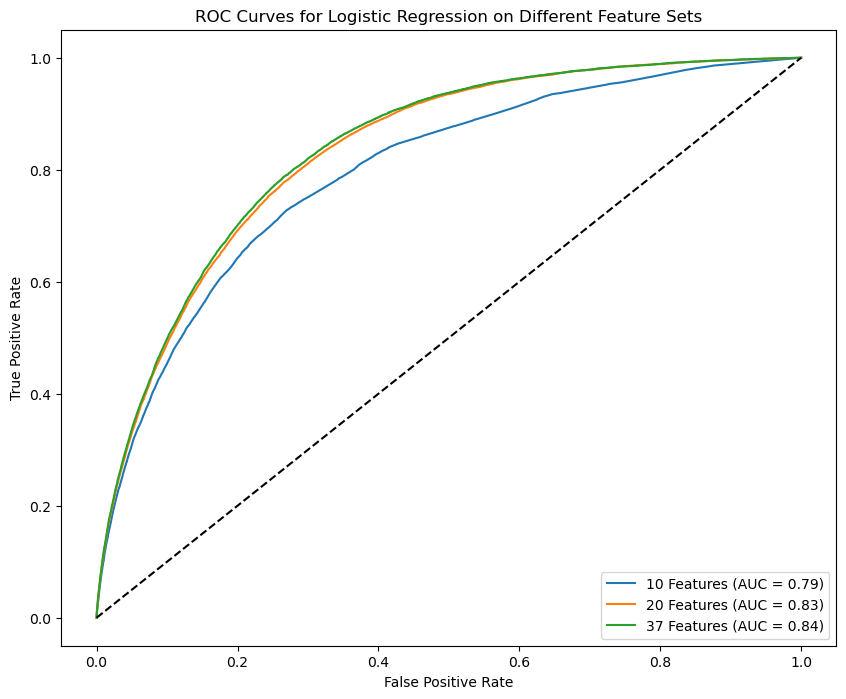

In [74]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for dataset, values in metrics.items():
    plt.plot(values["fpr"], values["tpr"], label=f"{dataset} (AUC = {values['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression on Different Feature Sets')
plt.legend(loc="lower right")
plt.show()

In [76]:
# 2. Evaluation with Cross-Validation
metrics_cv = {}  # Store cross-validation results

for name, model, X_train, y_train in [
    ("10 Features", log_reg_10, X_train_10, y_train_10),
    ("20 Features", log_reg_20, X_train_20, y_train_20),
    ("37 Features", log_reg_all, X_train_all, y_train_all)
]:
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    metrics_cv[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

# Print cross-validation results
for dataset, metric_values in metrics_cv.items():
    print(f"\nResults for {dataset} Dataset - Cross-Validation:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")


Results for 10 Features Dataset - Cross-Validation:
Accuracy: 0.91
Precision: 0.52
Recall: 0.09
F1-Score: 0.15
AUC: 0.79

Results for 20 Features Dataset - Cross-Validation:
Accuracy: 0.91
Precision: 0.54
Recall: 0.10
F1-Score: 0.17
AUC: 0.83

Results for 37 Features Dataset - Cross-Validation:
Accuracy: 0.91
Precision: 0.55
Recall: 0.11
F1-Score: 0.18
AUC: 0.84


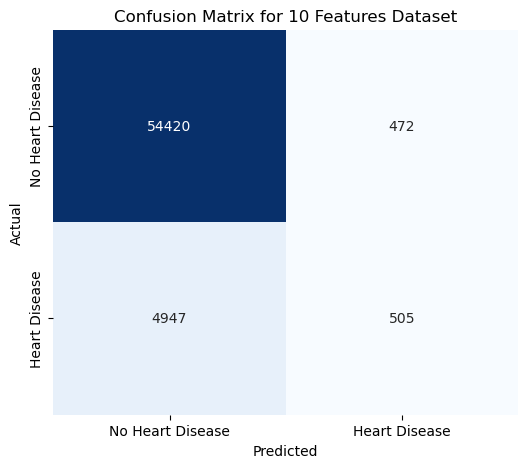

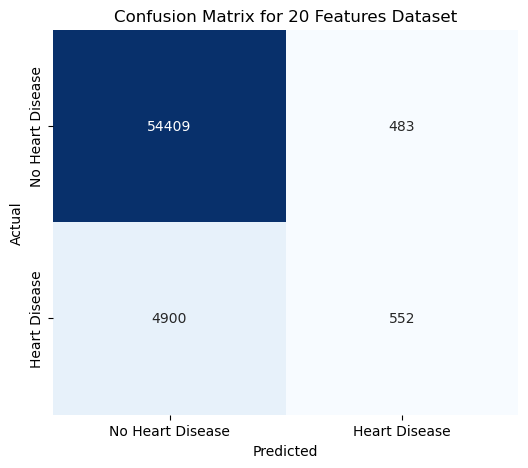

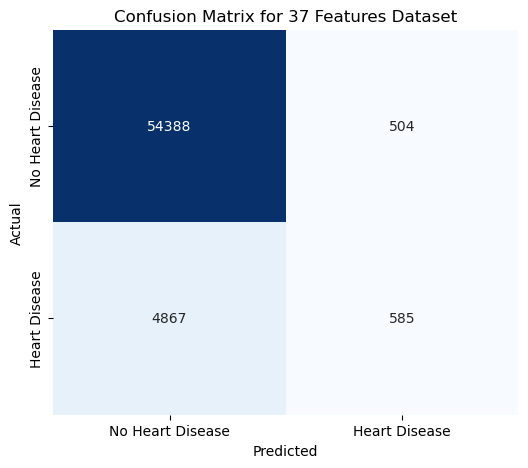

In [31]:
# 3. Confusion Matrices
for dataset, values in metrics.items():
    cm = confusion_matrix(values["y_test"], values["y_pred"])
    plt.figure(figsize=(6, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {dataset} Dataset')
    plt.show()

### Undersampling

In [33]:
# Initialize logistic regression models
log_reg_undersampled_10 = LogisticRegression(max_iter=1000, random_state=42)
log_reg_undersampled_20 = LogisticRegression(max_iter=1000, random_state=42)
log_reg_undersampled_all = LogisticRegression(max_iter=1000, random_state=42)

In [35]:
# Train the models
log_reg_undersampled_10.fit(X_train_under_10, y_train_under_10)
log_reg_undersampled_20.fit(X_train_under_20, y_train_under_20)
log_reg_undersampled_all.fit(X_train_under_all, y_train_under_all)

LogisticRegression(max_iter=1000, random_state=42)

In [37]:
# Predictions for each dataset
y_pred_undersampled_10 = log_reg_undersampled_10.predict(X_test_under_10)
y_pred_undersampled_20 = log_reg_undersampled_20.predict(X_test_under_20)
y_pred_undersampled_all = log_reg_undersampled_all.predict(X_test_under_all)

In [39]:
# 1. Evaluation with Train/Test Split

metrics = {}
for name, y_test, y_pred, model, X_train, y_train in [
    ("10 Features", y_test_under_10, y_pred_undersampled_10, log_reg_undersampled_10, X_train_under_10, y_train_under_10),
    ("20 Features", y_test_under_20, y_pred_undersampled_20, log_reg_undersampled_20, X_train_under_20, y_train_under_20),
    ("37 Features", y_test_under_all, y_pred_undersampled_all, log_reg_undersampled_all, X_train_under_all, y_train_under_all)
]:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validate for ROC and AUC
    y_scores = cross_val_predict(model, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    auc = roc_auc_score(y_train, y_scores)
    
    # Store the results
    metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "y_test": y_test,
        "y_pred": y_pred
    }
    metrics[name]["fpr"] = fpr
    metrics[name]["tpr"] = tpr

# Print results
for dataset, metric_values in metrics.items():
    print(f"\nResults for {dataset} Dataset (Undersampled):")
    for metric, value in metric_values.items():
        if metric in ["fpr", "tpr", "y_test", "y_pred"]:
            continue
        print(f"{metric}: {value:.2f}")


Results for 10 Features Dataset (Undersampled):
Accuracy: 0.71
Precision: 0.74
Recall: 0.66
F1-Score: 0.70
AUC: 0.79

Results for 20 Features Dataset (Undersampled):
Accuracy: 0.75
Precision: 0.75
Recall: 0.77
F1-Score: 0.76
AUC: 0.83

Results for 37 Features Dataset (Undersampled):
Accuracy: 0.76
Precision: 0.75
Recall: 0.78
F1-Score: 0.76
AUC: 0.84


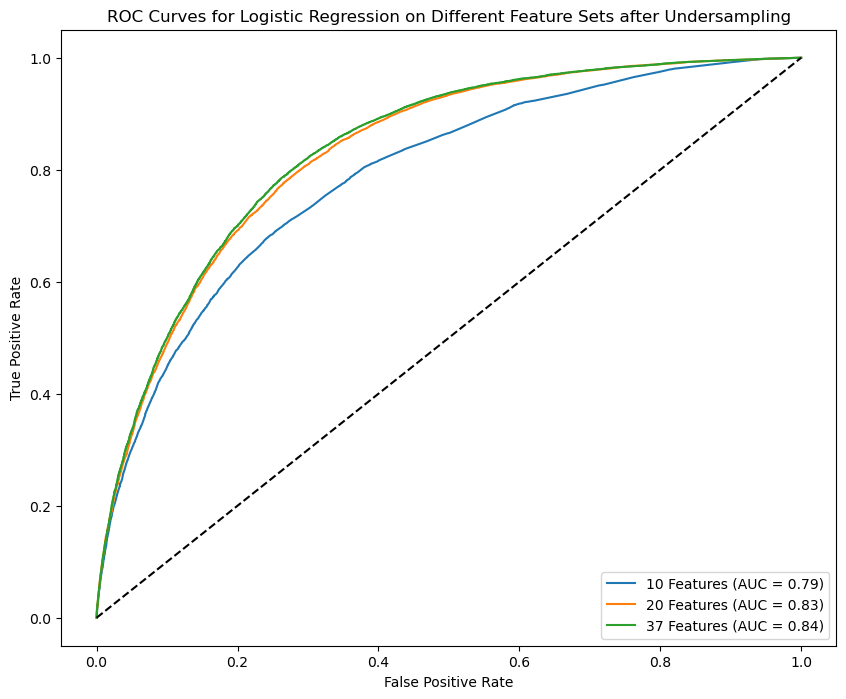

In [41]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for dataset, values in metrics.items():
    plt.plot(values["fpr"], values["tpr"], label=f"{dataset} (AUC = {values['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression on Different Feature Sets after Undersampling')
plt.legend(loc="lower right")
plt.show()

In [43]:
# 2. Evaluation with Cross-Validation
metrics_cv = {}  # Store cross-validation results

for name, model, X_train, y_train in [
    ("10 Features", log_reg_undersampled_10, X_train_under_10, y_train_under_10),
    ("20 Features", log_reg_undersampled_20, X_train_under_20, y_train_under_20),
    ("37 Features", log_reg_undersampled_all, X_train_under_all, y_train_under_all)
]:
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    metrics_cv[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

# Print cross-validation results
for dataset, metric_values in metrics_cv.items():
    print(f"\nResults for {dataset} Dataset (Undersampled) - Cross-Validation:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")


Results for 10 Features Dataset (Undersampled) - Cross-Validation:
Accuracy: 0.72
Precision: 0.74
Recall: 0.66
F1-Score: 0.70
AUC: 0.79

Results for 20 Features Dataset (Undersampled) - Cross-Validation:
Accuracy: 0.75
Precision: 0.75
Recall: 0.77
F1-Score: 0.76
AUC: 0.83

Results for 37 Features Dataset (Undersampled) - Cross-Validation:
Accuracy: 0.76
Precision: 0.75
Recall: 0.78
F1-Score: 0.77
AUC: 0.84


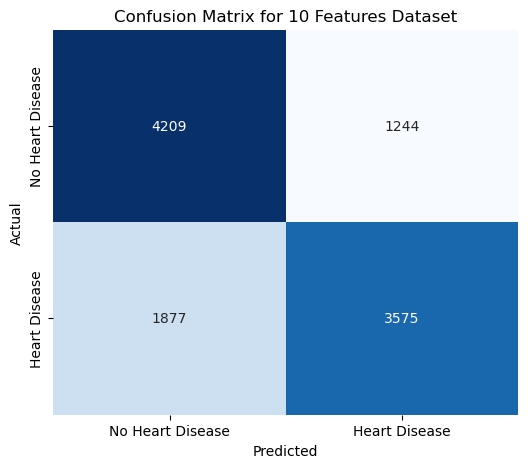

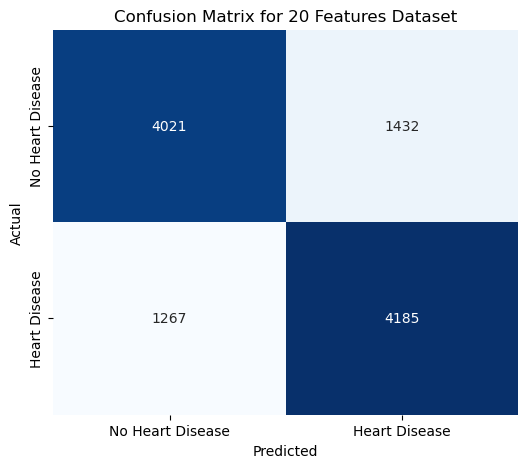

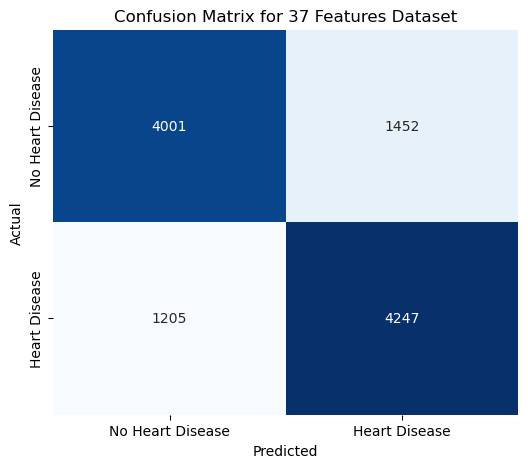

In [45]:
# 3. Confusion Matrices
for dataset, values in metrics.items():
    cm = confusion_matrix(values["y_test"], values["y_pred"])
    plt.figure(figsize=(6, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {dataset} Dataset')
    plt.show()

## Random Forest

### Entire Dataset Sample

In [47]:
# Initialize separate RandomForestClassifier instances for each feature set
rf_clf_10 = RandomForestClassifier(random_state=42)
rf_clf_20 = RandomForestClassifier(random_state=42)
rf_clf_all = RandomForestClassifier(random_state=42)


In [49]:
# Train each classifier on the respective training set
rf_clf_10.fit(X_train_10, y_train_10)
rf_clf_20.fit(X_train_20, y_train_20)
rf_clf_all.fit(X_train_all, y_train_all)

RandomForestClassifier(random_state=42)

In [22]:
# Predictions for each dataset
y_pred_10 = rf_clf_10.predict(X_test_10)
y_pred_20 = rf_clf_20.predict(X_test_20)
y_pred_all = rf_clf_all.predict(X_test_all)

In [51]:
# 1. Evaluation with Train/Test Split

metrics = {}
for name, y_test, y_pred, rf_clf, X_train, y_train in [
    ("10 Features", y_test_10, y_pred_10, rf_clf_10, X_train_10, y_train_10),
    ("20 Features", y_test_20, y_pred_20, rf_clf_20, X_train_20, y_train_20),
    ("37 Features", y_test_all, y_pred_all, rf_clf_all, X_train_all, y_train_all)
]:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validate for ROC and AUC
    y_scores = cross_val_predict( rf_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    auc = roc_auc_score(y_train, y_scores)
    
    # Store the results
    metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "y_test": y_test,
        "y_pred": y_pred
    }
    metrics[name]["fpr"] = fpr
    metrics[name]["tpr"] = tpr

# Print results
for dataset, metric_values in metrics.items():
    print(f"\nResults for {dataset} Dataset:")
    for metric, value in metric_values.items():
        if metric in ["fpr", "tpr", "y_test", "y_pred"]:
            continue
        print(f"{metric}: {value:.2f}")


Results for 10 Features Dataset:
Accuracy: 0.91
Precision: 0.52
Recall: 0.09
F1-Score: 0.16
AUC: 0.77

Results for 20 Features Dataset:
Accuracy: 0.91
Precision: 0.53
Recall: 0.10
F1-Score: 0.17
AUC: 0.77

Results for 37 Features Dataset:
Accuracy: 0.91
Precision: 0.54
Recall: 0.11
F1-Score: 0.18
AUC: 0.78


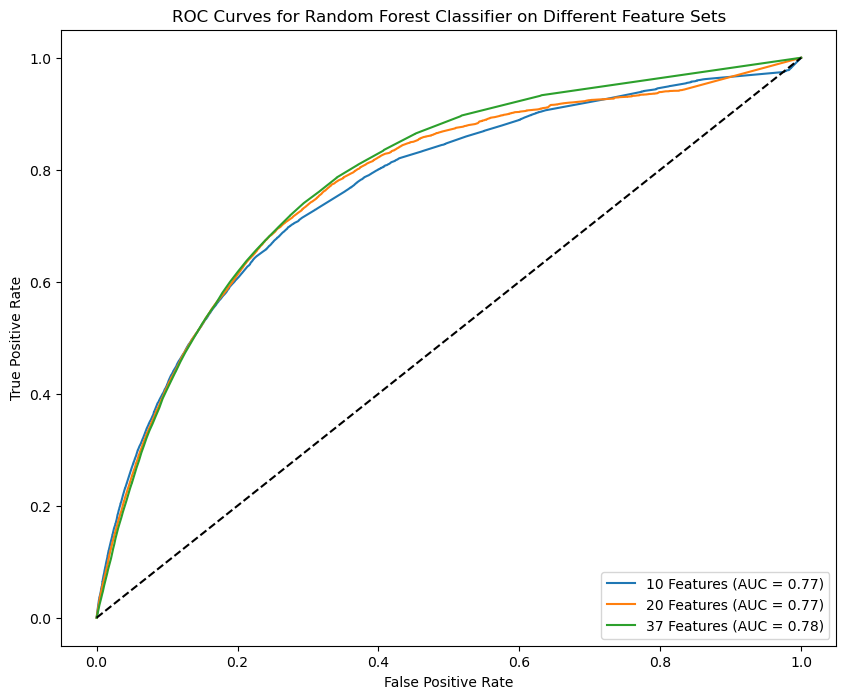

In [24]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for dataset, values in metrics.items():
    plt.plot(values["fpr"], values["tpr"], label=f"{dataset} (AUC = {values['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest Classifier on Different Feature Sets')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 2. Evaluation with Cross-Validation
metrics_cv = {}  # Store cross-validation results

for name, model, X_train, y_train in [
    ("10 Features", log_reg_10, X_train_10, y_train_10),
    ("20 Features", log_reg_20, X_train_20, y_train_20),
    ("37 Features", log_reg_all, X_train_all, y_train_all)
]:
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    metrics_cv[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

# Print cross-validation results
for dataset, metric_values in metrics_cv.items():
    print(f"\nResults for {dataset} Dataset - Cross-Validation:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")

In [ ]:
# 3. Confusion Matrices
for dataset, values in metrics.items():
    cm = confusion_matrix(values["y_test"], values["y_pred"])
    plt.figure(figsize=(6, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {dataset} Dataset')
    plt.show()

### Undersampling

In [25]:
# Initialize separate RandomForestClassifier instances for each feature set
rf_clf_10_resample = RandomForestClassifier(random_state=42)
rf_clf_20_resample = RandomForestClassifier(random_state=42)
rf_clf_all_resample = RandomForestClassifier(random_state=42)

In [26]:
# Train each classifier on the respective training set
rf_clf_10_resample.fit(X_train_under_10, y_train_under_10)
rf_clf_20_resample.fit(X_train_under_20, y_train_under_20)
rf_clf_all_resample.fit(X_train_under_all, y_train_under_all)

RandomForestClassifier(random_state=42)

In [27]:
# Predictions for each undersampled dataset
y_pred_resample_10 = rf_clf_10_resample.predict(X_test_under_10)
y_pred_resample_20 = rf_clf_20_resample.predict(X_test_under_20)
y_pred_resample_37 = rf_clf_all_resample.predict(X_test_under_all)

In [28]:
# 1. Evaluation with Train/Test Split

metrics = {}
for name, y_test, y_pred, rf_clf, X_train, y_train in [
    ("10 Features", y_test_under_10, y_pred_resample_10, rf_clf_10_resample, X_train_under_10, y_train_under_10),
    ("20 Features", y_test_under_20, y_pred_resample_20, rf_clf_20_resample, X_train_under_20, y_train_under_20),
    ("37 Features", y_test_under_all, y_pred_resample_37, rf_clf_all_resample, X_train_under_all, y_train_under_all)
]:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validate for ROC and AUC
    y_scores = cross_val_predict(rf_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    auc = roc_auc_score(y_train, y_scores)
    
    # Store the results
    metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "y_test": y_test,
        "y_pred": y_pred
    }
    metrics[name]["fpr"] = fpr
    metrics[name]["tpr"] = tpr

# Print results
for dataset, metric_values in metrics.items():
    print(f"\nResults for {dataset} Dataset (Undersampled):")
    for metric, value in metric_values.items():
        if metric in ["fpr", "tpr", "y_test", "y_pred"]:
            continue
        print(f"{metric}: {value:.2f}")


Results for 10 Features Dataset (Undersampled):
Accuracy: 0.71
Precision: 0.72
Recall: 0.68
F1-Score: 0.70
AUC: 0.77

Results for 20 Features Dataset (Undersampled):
Accuracy: 0.73
Precision: 0.73
Recall: 0.74
F1-Score: 0.73
AUC: 0.80

Results for 37 Features Dataset (Undersampled):
Accuracy: 0.74
Precision: 0.72
Recall: 0.77
F1-Score: 0.74
AUC: 0.81


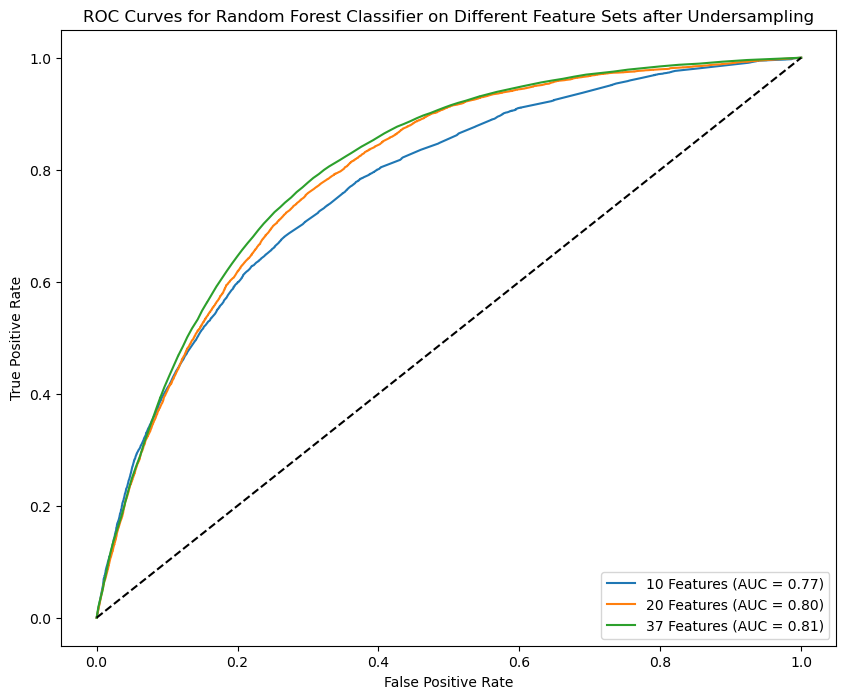

In [29]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for dataset, values in metrics.items():
    plt.plot(values["fpr"], values["tpr"], label=f"{dataset} (AUC = {values['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest Classifier on Different Feature Sets after Undersampling')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 2. Evaluation with Cross-Validation
metrics_cv = {}  # Store cross-validation results

for name, model, X_train, y_train in [
    ("10 Features", log_reg_10, X_train_10, y_train_10),
    ("20 Features", log_reg_20, X_train_20, y_train_20),
    ("37 Features", log_reg_all, X_train_all, y_train_all)
]:
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    metrics_cv[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

# Print cross-validation results
for dataset, metric_values in metrics_cv.items():
    print(f"\nResults for {dataset} Dataset - Cross-Validation:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")

In [ ]:
# 3. Confusion Matrices
for dataset, values in metrics.items():
    cm = confusion_matrix(values["y_test"], values["y_pred"])
    plt.figure(figsize=(6, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {dataset} Dataset')
    plt.show()

## Decision Tree Classifier

### Entire Dataset Sample

In [30]:
# Initialize separate DecisionTreeClassifier instances for each feature set
dt_clf_10 = DecisionTreeClassifier(random_state=42)
dt_clf_20 = DecisionTreeClassifier(random_state=42)
dt_clf_all = DecisionTreeClassifier(random_state=42)

In [31]:
# Train each classifier on the respective training set
dt_clf_10.fit(X_train_10, y_train_10)
dt_clf_20.fit(X_train_20, y_train_20)
dt_clf_all.fit(X_train_all, y_train_all)

DecisionTreeClassifier(random_state=42)

In [32]:
# Predictions for each dataset
y_pred_10 = dt_clf_10.predict(X_test_10)
y_pred_20 = dt_clf_20.predict(X_test_20)
y_pred_all = dt_clf_all.predict(X_test_all)

In [33]:
# 1. Evaluation with Train/Test Split

metrics = {}
for name, y_test, y_pred, dt_clf, X_train, y_train in [
    ("10 Features", y_test_10, y_pred_10, dt_clf_10, X_train_10, y_train_10),
    ("20 Features", y_test_20, y_pred_20, dt_clf_20, X_train_20, y_train_20),
    ("37 Features", y_test_all, y_pred_all, dt_clf_all, X_train_all, y_train_all)
]:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validate for ROC and AUC
    y_scores = cross_val_predict(dt_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    auc = roc_auc_score(y_train, y_scores)
    
    # Store the results
    metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "y_test": y_test,
        "y_pred": y_pred
    }
    metrics[name]["fpr"] = fpr
    metrics[name]["tpr"] = tpr

# Print results
for dataset, metric_values in metrics.items():
    print(f"\nResults for {dataset} Dataset:")
    for metric, value in metric_values.items():
        if metric in ["fpr", "tpr", "y_test", "y_pred"]:
            continue
        print(f"{metric}: {value:.2f}")



Results for 10 Features Dataset:
Accuracy: 0.91
Precision: 0.46
Recall: 0.07
F1-Score: 0.12
AUC: 0.74

Results for 20 Features Dataset:
Accuracy: 0.90
Precision: 0.38
Recall: 0.12
F1-Score: 0.19
AUC: 0.68

Results for 37 Features Dataset:
Accuracy: 0.85
Precision: 0.23
Recall: 0.25
F1-Score: 0.24
AUC: 0.59


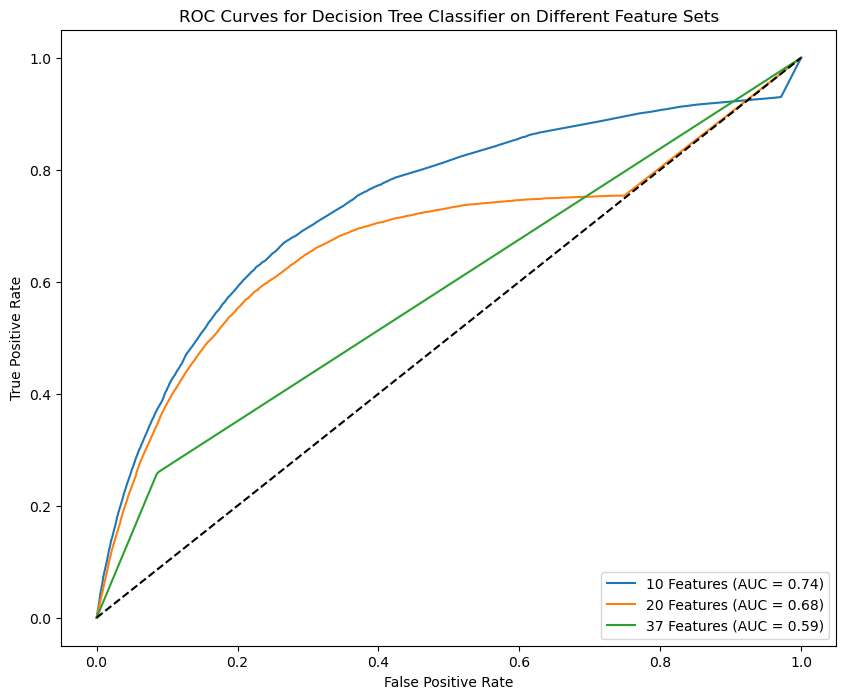

In [34]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for dataset, values in metrics.items():
    plt.plot(values["fpr"], values["tpr"], label=f"{dataset} (AUC = {values['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree Classifier on Different Feature Sets')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# 2. Evaluation with Cross-Validation
metrics_cv = {}  # Store cross-validation results

for name, model, X_train, y_train in [
    ("10 Features", log_reg_10, X_train_10, y_train_10),
    ("20 Features", log_reg_20, X_train_20, y_train_20),
    ("37 Features", log_reg_all, X_train_all, y_train_all)
]:
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    metrics_cv[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

# Print cross-validation results
for dataset, metric_values in metrics_cv.items():
    print(f"\nResults for {dataset} Dataset - Cross-Validation:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")

In [ ]:
# 3. Confusion Matrices
for dataset, values in metrics.items():
    cm = confusion_matrix(values["y_test"], values["y_pred"])
    plt.figure(figsize=(6, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {dataset} Dataset')
    plt.show()

### Undersampling

In [35]:
# Initialize separate DecisionTreeClassifier instances for each feature set
dt_clf_10_resample = DecisionTreeClassifier(random_state=42)
dt_clf_20_resample = DecisionTreeClassifier(random_state=42)
dt_clf_all_resample = DecisionTreeClassifier(random_state=42)

In [36]:
# Train each classifier on the respective training set
dt_clf_10_resample.fit(X_train_under_10, y_train_under_10)
dt_clf_20_resample.fit(X_train_under_20, y_train_under_20)
dt_clf_all_resample.fit(X_train_under_all, y_train_under_all)

DecisionTreeClassifier(random_state=42)

In [37]:
# Predictions for each undersampled dataset
y_pred_resample_10 = dt_clf_10_resample.predict(X_test_under_10)
y_pred_resample_20 = dt_clf_20_resample.predict(X_test_under_20)
y_pred_resample_37 = dt_clf_all_resample.predict(X_test_under_all)

In [38]:
# 1. Evaluation with Train/Test Split

metrics = {}
for name, y_test, y_pred, dt_clf, X_train, y_train in [
    ("10 Features", y_test_under_10, y_pred_resample_10, dt_clf_10_resample, X_train_under_10, y_train_under_10),
    ("20 Features", y_test_under_20, y_pred_resample_20, dt_clf_20_resample, X_train_under_20, y_train_under_20),
    ("37 Features", y_test_under_all, y_pred_resample_37, dt_clf_all_resample, X_train_under_all, y_train_under_all)
]:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validate for ROC and AUC
    y_scores = cross_val_predict(dt_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    auc = roc_auc_score(y_train, y_scores)
    
    # Store the results
    metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "y_test": y_test,
        "y_pred": y_pred
    }
    metrics[name]["fpr"] = fpr
    metrics[name]["tpr"] = tpr

# Print results
for dataset, metric_values in metrics.items():
    print(f"\nResults for {dataset} Dataset (Undersampled):")
    for metric, value in metric_values.items():
        if metric in ["fpr", "tpr", "y_test", "y_pred"]:
            continue
        print(f"{metric}: {value:.2f}")


Results for 10 Features Dataset (Undersampled):
Accuracy: 0.70
Precision: 0.72
Recall: 0.66
F1-Score: 0.69
AUC: 0.77

Results for 20 Features Dataset (Undersampled):
Accuracy: 0.71
Precision: 0.72
Recall: 0.68
F1-Score: 0.70
AUC: 0.75

Results for 37 Features Dataset (Undersampled):
Accuracy: 0.66
Precision: 0.66
Recall: 0.66
F1-Score: 0.66
AUC: 0.67


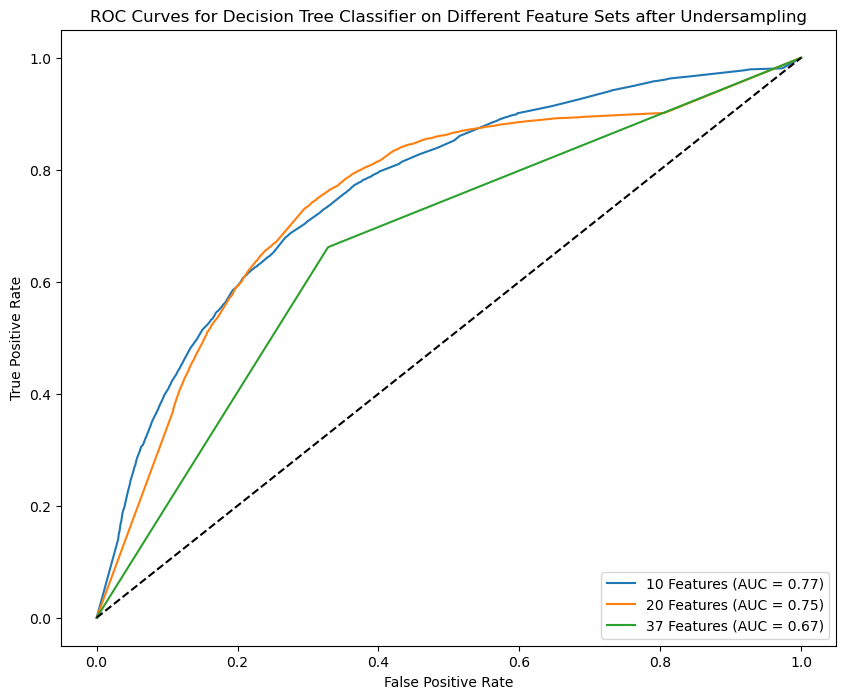

In [39]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for dataset, values in metrics.items():
    plt.plot(values["fpr"], values["tpr"], label=f"{dataset} (AUC = {values['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree Classifier on Different Feature Sets after Undersampling')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# 2. Evaluation with Cross-Validation
metrics_cv = {}  # Store cross-validation results

for name, model, X_train, y_train in [
    ("10 Features", log_reg_10, X_train_10, y_train_10),
    ("20 Features", log_reg_20, X_train_20, y_train_20),
    ("37 Features", log_reg_all, X_train_all, y_train_all)
]:
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    metrics_cv[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

# Print cross-validation results
for dataset, metric_values in metrics_cv.items():
    print(f"\nResults for {dataset} Dataset - Cross-Validation:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")

In [ ]:
# 3. Confusion Matrices
for dataset, values in metrics.items():
    cm = confusion_matrix(values["y_test"], values["y_pred"])
    plt.figure(figsize=(6, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {dataset} Dataset')
    plt.show()

## KNN Classifier

### Entire dataset sample

In [40]:
# Initialize the kNN classifier with k=5 and train it on each training set
knn_clf_10 = KNeighborsClassifier(n_neighbors=5)
knn_clf_20 = KNeighborsClassifier(n_neighbors=5)
knn_clf_all = KNeighborsClassifier(n_neighbors=5)

# Training for original datasets
knn_clf_10.fit(X_train_10, y_train_10)
knn_clf_20.fit(X_train_20, y_train_20)
knn_clf_all.fit(X_train_all, y_train_all)

KNeighborsClassifier()

In [41]:
# Predictions for each dataset
y_pred_10 = knn_clf_10.predict(X_test_10)
y_pred_20 = knn_clf_20.predict(X_test_20)
y_pred_all = knn_clf_all.predict(X_test_all)

In [42]:
# Calculate accuracy, precision, recall, F1-Score for each dataset
accuracy_10 = accuracy_score(y_test_10, y_pred_10)
precision_10 = precision_score(y_test_10, y_pred_10)
recall_10 = recall_score(y_test_10, y_pred_10)
f1_10 = f1_score(y_test_10, y_pred_10)

accuracy_20 = accuracy_score(y_test_20, y_pred_20)
precision_20 = precision_score(y_test_20, y_pred_20)
recall_20 = recall_score(y_test_20, y_pred_20)
f1_20 = f1_score(y_test_20, y_pred_20)

accuracy_37 = accuracy_score(y_test_all, y_pred_all)
precision_37 = precision_score(y_test_all, y_pred_all)
recall_37 = recall_score(y_test_all, y_pred_all)
f1_37 = f1_score(y_test_all, y_pred_all)

In [43]:
# Cross-validation predictions for ROC and AUC calculation
y_scores_10 = cross_val_predict(knn_clf_10, X_train_10, y_train_10, cv=3, method="predict_proba")[:, 1]
fpr_10, tpr_10, _ = roc_curve(y_train_10, y_scores_10)
roc_auc_10 = roc_auc_score(y_train_10, y_scores_10)

y_scores_20 = cross_val_predict(knn_clf_20, X_train_20, y_train_20, cv=3, method="predict_proba")[:, 1]
fpr_20, tpr_20, _ = roc_curve(y_train_20, y_scores_20)
roc_auc_20 = roc_auc_score(y_train_20, y_scores_20)

y_scores_37 = cross_val_predict(knn_clf_all, X_train_all, y_train_all, cv=3, method="predict_proba")[:, 1]
fpr_37, tpr_37, _ = roc_curve(y_train_all, y_scores_37)
roc_auc_37 = roc_auc_score(y_train_all, y_scores_37)

In [44]:
# Print the results for each dataset
print("Results for 10 Features Dataset:")
print(f"Accuracy: {accuracy_10:.2f}")
print(f"Precision: {precision_10:.2f}")
print(f"Recall: {recall_10:.2f}")
print(f"F1-Score: {f1_10:.2f}")
print(f"AUC: {roc_auc_10:.2f}")
print("\n")

print("Results for 20 Features Dataset:")
print(f"Accuracy: {accuracy_20:.2f}")
print(f"Precision: {precision_20:.2f}")
print(f"Recall: {recall_20:.2f}")
print(f"F1-Score: {f1_20:.2f}")
print(f"AUC: {roc_auc_20:.2f}")
print("\n")

print("Results for All Features Dataset:")
print(f"Accuracy: {accuracy_37:.2f}")
print(f"Precision: {precision_37:.2f}")
print(f"Recall: {recall_37:.2f}")
print(f"F1-Score: {f1_37:.2f}")
print(f"AUC: {roc_auc_37:.2f}")

Results for 10 Features Dataset:
Accuracy: 0.90
Precision: 0.36
Recall: 0.13
F1-Score: 0.19
AUC: 0.64


Results for 20 Features Dataset:
Accuracy: 0.90
Precision: 0.37
Recall: 0.14
F1-Score: 0.20
AUC: 0.70


Results for All Features Dataset:
Accuracy: 0.90
Precision: 0.31
Recall: 0.08
F1-Score: 0.13
AUC: 0.68


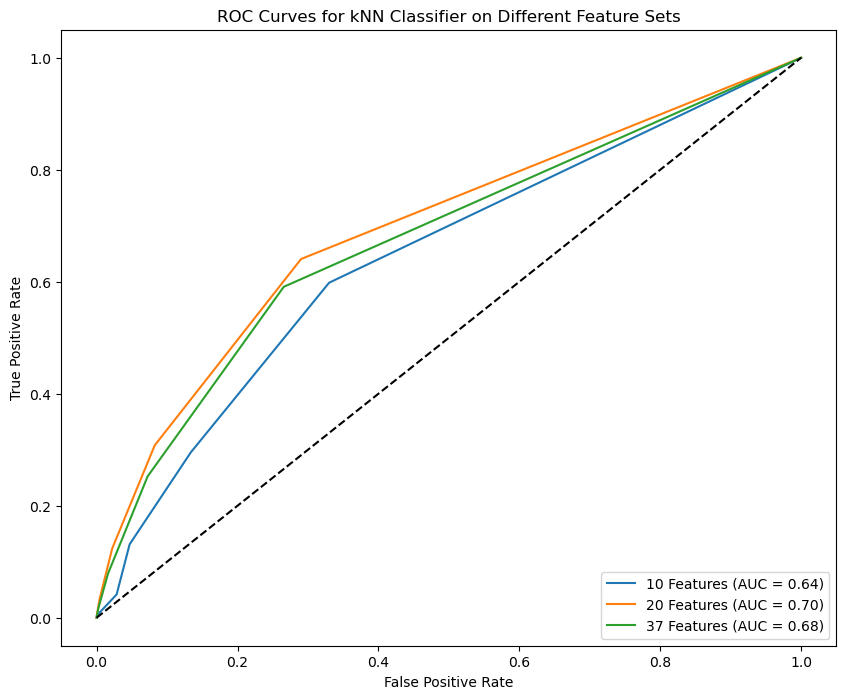

In [45]:
# Plotting the ROC Curves for the datasets (original)
plt.figure(figsize=(10, 8))
plt.plot(fpr_10, tpr_10, label="10 Features (AUC = {:.2f})".format(roc_auc_10))
plt.plot(fpr_20, tpr_20, label="20 Features (AUC = {:.2f})".format(roc_auc_20))
plt.plot(fpr_37, tpr_37, label="37 Features (AUC = {:.2f})".format(roc_auc_37))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for kNN Classifier on Different Feature Sets')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# 2. Evaluation with Cross-Validation
metrics_cv = {}  # Store cross-validation results

for name, model, X_train, y_train in [
    ("10 Features", log_reg_10, X_train_10, y_train_10),
    ("20 Features", log_reg_20, X_train_20, y_train_20),
    ("37 Features", log_reg_all, X_train_all, y_train_all)
]:
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    metrics_cv[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

# Print cross-validation results
for dataset, metric_values in metrics_cv.items():
    print(f"\nResults for {dataset} Dataset - Cross-Validation:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")

In [ ]:
# 3. Confusion Matrices
for dataset, values in metrics.items():
    cm = confusion_matrix(values["y_test"], values["y_pred"])
    plt.figure(figsize=(6, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {dataset} Dataset')
    plt.show()

### Undersampling

In [46]:
# Initialize and train kNN classifiers for each undersampled dataset
knn_resample_10 = KNeighborsClassifier(n_neighbors=5)
knn_resample_20 = KNeighborsClassifier(n_neighbors=5)
knn_resample_all = KNeighborsClassifier(n_neighbors=5)

# training the undersampled datasets
knn_resample_10.fit(X_train_under_10, y_train_under_10)
knn_resample_20.fit(X_train_under_20, y_train_under_20)
knn_resample_all.fit(X_train_under_all, y_train_under_all)

KNeighborsClassifier()

In [47]:
# Predictions for each undersampled dataset
y_pred_resample_10 = knn_resample_10.predict(X_test_under_10)
y_pred_resample_20 = knn_resample_20.predict(X_test_under_20)
y_pred_resample_all = knn_resample_all.predict(X_test_under_all)

In [48]:
# 1. Evaluation with Train/Test Split

metrics = {}
roc_values = {}

for name, y_test, y_pred, X_train, y_train, knn_clf in [
    ("10 Features", y_test_under_10, y_pred_resample_10, X_train_under_10, y_train_under_10, knn_resample_10),
    ("20 Features", y_test_under_20, y_pred_resample_20, X_train_under_20, y_train_under_20, knn_resample_20),
    ("37 Features", y_test_under_all, y_pred_resample_all, X_train_under_all, y_train_under_all, knn_resample_all)
]:
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation predictions for ROC and AUC calculation
    y_scores = cross_val_predict(knn_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    auc = roc_auc_score(y_train, y_scores)
    
    # Store the metrics
    metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

    # Store ROC values for plotting
    roc_values[name] = (fpr, tpr, auc)

# Print the results
for dataset, metric_values in metrics.items():
    print(f"\nResults for {dataset} Dataset (Undersampled):")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")


Results for 10 Features Dataset (Undersampled):
Accuracy: 0.66
Precision: 0.63
Recall: 0.76
F1-Score: 0.69
AUC: 0.73

Results for 20 Features Dataset (Undersampled):
Accuracy: 0.71
Precision: 0.69
Recall: 0.74
F1-Score: 0.72
AUC: 0.77

Results for 37 Features Dataset (Undersampled):
Accuracy: 0.69
Precision: 0.69
Recall: 0.70
F1-Score: 0.70
AUC: 0.74


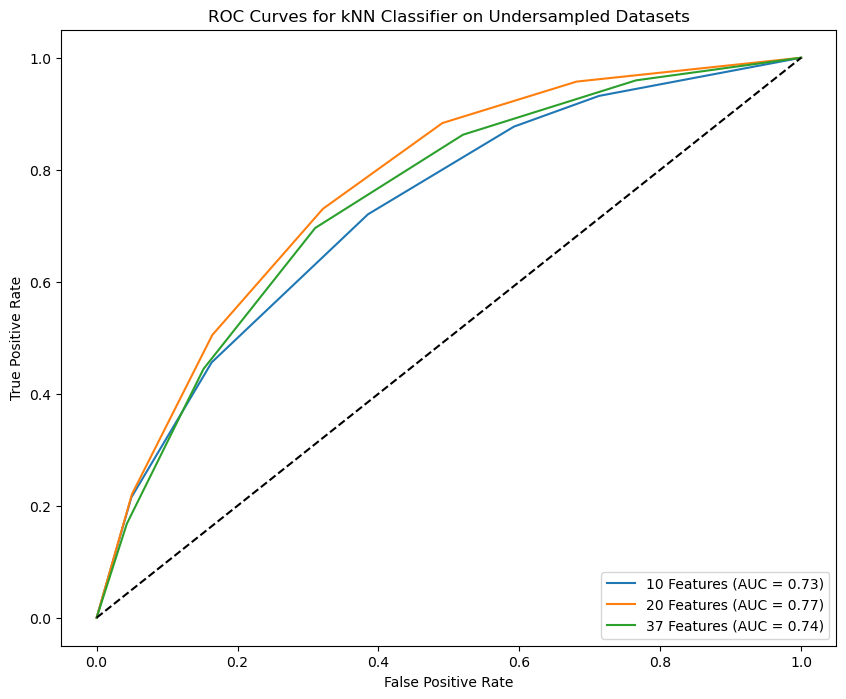

In [49]:
# Plotting the ROC Curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, auc) in roc_values.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plotting the random classifier line
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for a random classifier

# Labels and Title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for kNN Classifier on Undersampled Datasets')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 2. Evaluation with Cross-Validation
metrics_cv = {}  # Store cross-validation results

for name, model, X_train, y_train in [
    ("10 Features", log_reg_10, X_train_10, y_train_10),
    ("20 Features", log_reg_20, X_train_20, y_train_20),
    ("37 Features", log_reg_all, X_train_all, y_train_all)
]:
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    metrics_cv[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

# Print cross-validation results
for dataset, metric_values in metrics_cv.items():
    print(f"\nResults for {dataset} Dataset - Cross-Validation:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.2f}")

In [ ]:
# 3. Confusion Matrices
for dataset, values in metrics.items():
    cm = confusion_matrix(values["y_test"], values["y_pred"])
    plt.figure(figsize=(6, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {dataset} Dataset')
    plt.show()

## Grid Search
One option would be to try to tune the hyperparameters manually, until you find a great combination of hyperparameter values. Instead, you can use Scikit-Learn’s GridSearchCV to optimize hyperparameters for you. 


`GridSearchCV` <- Important to learn <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">Documentation Link</a>

In [50]:
# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score), 
    'roc_auc': make_scorer(roc_auc_score)

}


### Grid Search for Decision Tree

In [51]:
from sklearn.metrics import accuracy_score, classification_report

In [52]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Run grid search and evaluate each dataset
datasets = [
    ('10 Features', X_train_10, y_train_10, X_test_10, y_test_10),
    ('20 Features', X_train_20, y_train_20, X_test_20, y_test_20),
    ('All Features', X_train_all, y_train_all, X_test_all, y_test_all)
]

for name, X_train, y_train, X_test, y_test in datasets:
    print(f"\nGrid Search for {name} Dataset")
    
    # Initialize DecisionTreeClassifier and GridSearchCV
    dt = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Fit the model with grid search
    grid_search.fit(X_train, y_train)
    
    # Get best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Parameters for {name}: {best_params}")
    print(f"Best Cross-Validation Score for {name}: {best_score:.4f}")
    
    # Evaluate on the test set
    best_dt = grid_search.best_estimator_
    y_pred = best_dt.predict(X_test)
    
    # Print classification report for evaluation
    print(f"Test Set Results for this text {name}:\n", classification_report(y_test, y_pred))



Grid Search for 10 Features Dataset


KeyboardInterrupt: 

### Grid Search for Random Forest